In [1]:
import requests
import pandas as pd
import json
import numpy as np
import requests
import json
import re
import matplotlib.pyplot as plt
%matplotlib inline
import unicodedata

### Using yelp API, collect data from Chicago, New York, San Francisco (all Michelin reviewed cities) & DC.

In [2]:
authorization = {'Authorization': ***** }

In [14]:
dc_yelp = []

for offset in range(0, 300, 20):
    try:
        response = requests.get('https://api.yelp.com/v3/businesses/search?term=restaurants&location=Washington,+DC&offset={}&sort_by=rating&price=2,3,4'.format(offset), headers=authorization)
        dc_yelp.append(json.loads(response.text))
    except:
        pass

In [19]:
chicago_yelp = []

for offset in range(0, 300, 20):
    try:
        response = requests.get('https://api.yelp.com/v3/businesses/search?term=restaurants&location=Chicago&offset={}&sort_by=rating&price=2,3,4'.format(offset), headers=authorization)
        chicago_yelp.append(json.loads(response.text))
    except:
        pass

In [20]:
ny_yelp = []

for offset in range(0, 300, 20):
    try:
        response = requests.get('https://api.yelp.com/v3/businesses/search?term=restaurants&location=New+York&offset={}&sort_by=rating&price=2,3,4'.format(offset), headers=authorization)
        ny_yelp.append(json.loads(response.text))
    except:
        pass

In [21]:
sf_yelp = []

for offset in range(0, 300, 20):
    try:
        response = requests.get('https://api.yelp.com/v3/businesses/search?term=restaurants&location=San+Francisco&offset={}&sort_by=rating&price=2,3,4'.format(offset), headers=authorization)
        sf_yelp.append(json.loads(response.text))
    except:
        pass

### Read data into dataframes.

In [9]:
def df_maker(yelp):
    rest_id = []
    name = []
    rating = []
    review_count = []
    price = []
    categories = []
    for dict in yelp:
        for k, v in dict.iteritems():
            if k == 'businesses':
                for dict in v:
                    for inner_k, inner_v in dict.iteritems():
                        if inner_k == 'id':
                            rest_id.append(inner_v)
                        elif inner_k == 'name':
                            name.append(inner_v)
                        elif inner_k == 'rating':
                            rating.append(inner_v)
                        elif inner_k == 'review_count':
                            review_count.append(inner_v)
                        elif inner_k == 'price':
                            price.append(inner_v)
                        elif inner_k == 'categories':
                            aliases = []
                            for dict in inner_v:
                                for deep_k, deep_v in dict.iteritems():
                                    if deep_k == 'alias':
                                        aliases.append(deep_v)
                            categories.append(" ".join(aliases))
                                        
                            
    df = pd.DataFrame({ 'num_reviews': review_count, 
                        'price': price, 
                        'rating': rating,
                        'restaurant': name,
                        'rest_id': rest_id,
                        'category': categories })

    df = df[['restaurant', 'rest_id', 'rating', 'price', 'num_reviews', 'category']]
    return df

In [273]:
dc = df_maker(dc_yelp)
chi = df_maker(chicago_yelp)
sf = df_maker(sf_yelp)
ny = df_maker(ny_yelp)

In [27]:
dc.restaurant = dc.restaurant.apply(lambda x: unicodedata.normalize('NFKD', x).encode('ascii', 'ignore'))
sf.restaurant = sf.restaurant.apply(lambda x: unicodedata.normalize('NFKD', x).encode('ascii', 'ignore'))
ny.restaurant = ny.restaurant.apply(lambda x: unicodedata.normalize('NFKD', x).encode('ascii', 'ignore'))
chi.restaurant = chi.restaurant.apply(lambda x: unicodedata.normalize('NFKD', x).encode('ascii', 'ignore'))

### I prepared (manually) a list of all US Michelin starred restaurants. Since only some were picked on the first   sweep of yelp's API,  I'll need to do a second request, this time asking for specific restaurant names. If this creates duplicates (it will), I'll deal with them later.


In [249]:
stars = pd.read_csv('/users/nick/desktop/michelin_stars.csv')

In [250]:
sf_stars = []
for i in stars.loc[stars.SanFran.notnull()].SanFran:
    sf_stars.append(i)
    
ny_stars = []
for i in stars.loc[stars.NewYork.notnull()].NewYork:
    ny_stars.append(i)
    
chi_stars = []
for i in stars.loc[stars.Chicago.notnull()].Chicago:
    chi_stars.append(i)

In [251]:
sf_michelin = []

for i in stars.loc[stars.SanFran.notnull()].SanFran:
    response = requests.get('https://api.yelp.com/v3/businesses/search?term={}&location=San+Francisco&categories=restaurants'.format(i.replace(' ', '+')), headers=authorization)
    try:
        for r in range(response.json()['total']):
            if (response.json()['businesses'][r]['name'] in i.decode('utf-8') or i.decode('utf-8') in response.json()['businesses'][r]['name']):
                sf_michelin.append([response.json()['businesses'][r]])
    except:
        pass

In [237]:
ny_michelin = []

for i in stars.loc[stars.NewYork.notnull()].NewYork:
    response = requests.get('https://api.yelp.com/v3/businesses/search?term={}&location=New+York&categories=restaurants'.format(i.replace(' ', '+')), headers=authorization)
    try:
        for r in range(response.json()['total']):
            if (response.json()['businesses'][r]['name'] in i.decode('utf-8') or i.decode('utf-8') in response.json()['businesses'][r]['name']):
                if response.json()['businesses'][r]['review_count'] > 15:
                    ny_michelin.append([response.json()['businesses'][r]])
    except:
        pass

In [238]:
chi_michelin = []

for i in stars.loc[stars.Chicago.notnull()].Chicago:
    response = requests.get('https://api.yelp.com/v3/businesses/search?term={}&location=Chicago&categories=restaurants'.format(i.replace(' ', '+')), headers=authorization)
    try:
        for r in range(response.json()['total']):
            if (response.json()['businesses'][r]['name'] in i.decode('utf-8') or i.decode('utf-8') in response.json()['businesses'][r]['name']):
                chi_michelin.append([response.json()['businesses'][r]])
    except:
        pass


In [244]:
def df_maker_v2(reviews):
    rest_id = []
    name = []
    rating = []
    review_count = []
    price = []
    categories = []
    for list in reviews:
        for dict in list:
            for k, v in dict.iteritems():
                if k == 'id':
                    rest_id.append(v)
                elif k == 'name':
                    name.append(v)
                elif k == 'rating':
                    rating.append(v)
                elif k == 'review_count':
                    review_count.append(v)
                elif k == 'price':
                    price.append(v)
                elif k == 'categories':
                            aliases = []
                            for dict in v:
                                for inner_k, inner_v in dict.iteritems():
                                    if inner_k == 'alias':
                                        aliases.append(inner_v)
                            categories.append(" ".join(aliases))
                            
    df = pd.DataFrame({ 'num_reviews': review_count, 
                        'price': price, 
                        'rating': rating,
                        'restaurant': name,
                        'rest_id': rest_id,
                        'category': categories })

    df = df[['restaurant', 'rest_id', 'rating', 'price', 'num_reviews', 'category']]
    return df

In [252]:
sf_stars = df_maker_v2(sf_michelin)
ny_stars = df_maker_v2(ny_michelin)
chi_stars = df_maker_v2(chi_michelin)

### Updating dataframe with known Michelin star counts (from manually created list of Michelin starred restaurants).

In [255]:
for a, b in enumerate(sf_stars.restaurant):
    try:
        for x, y in enumerate(stars.loc[stars.SanFran.notnull()].SanFran):
            if (b.encode('utf-8') in y or y in b.encode('utf-8')):
                sf_stars.loc[a, 'stars'] = stars.loc[x, 'sf_stars']
    except:
        sf_stars.loc[a, 'stars'] = 0

In [256]:
for a, b in enumerate(ny_stars.restaurant):
    try:
        for x, y in enumerate(stars.loc[stars.NewYork.notnull()].NewYork):
            if (b.encode('utf-8') in y or y in b.encode('utf-8')):
                ny_stars.loc[a, 'stars'] = stars.loc[x, 'ny_stars']
    except:
        ny_stars.loc[a, 'stars'] = 0

In [257]:
for a, b in enumerate(chi_stars.restaurant):
    try:
        for x, y in enumerate(stars.loc[stars.Chicago.notnull()].Chicago):
            if (b.encode('utf-8') in y or y in b.encode('utf-8')):
                chi_stars.loc[a, 'stars'] = stars.loc[x, 'chi_stars']
    except:
        chi_stars.loc[a, 'stars'] = 0

In [274]:
ny = pd.concat([ny, ny_stars])
ny.reset_index(drop=True, inplace=True)
ny.stars.replace(np.nan, 0, inplace=True)

In [275]:
chi = pd.concat([chi, chi_stars])
chi.reset_index(drop=True, inplace=True)
chi.stars.replace(np.nan, 0, inplace=True)

In [276]:
sf = pd.concat([sf, sf_stars])
sf.reset_index(drop=True, inplace=True)
sf.stars.replace(np.nan, 0, inplace=True)

### DC touch-ups

In [1679]:
# Looking through the DC restaurants pulled from yelp, many were missing that I think will be Michelin contenders. 
# So, as above, I'll return to yelp's API. 
contenders = ["Kinship", "Marcel's", "Masseria", "Riggsby", "Garrison", "Mintwood", "Red Hen", "G by Mike Isabella", "Fiola Mare", "Le Diplomate", "Boss Shepherd's", "minibar", "The Dabney", "Metier", "Little Serow", "Source", "Obelisk", "Plume"]

In [1680]:
dc_contenders = []

for i in contenders:
    response = requests.get('https://api.yelp.com/v3/businesses/search?term={}&location=Washington,+DC&categories=restaurants'.format(i.replace(' ', '+')), headers=authorization)
    try:
        for r in range(response.json()['total']):
            if (response.json()['businesses'][r]['name'] in i.decode('utf-8') or i.decode('utf-8') in response.json()['businesses'][r]['name']):
                dc_contenders.append([response.json()['businesses'][r]])
    except:
        pass

In [2511]:
dc_contenders = df_maker_v2(dc_contenders)
dc = pd.concat([dc, dc_contenders])
dc.reset_index(drop=True, inplace=True)

### Because I made two passes through yelp's API, there are duplicates. Need to get rid of those. Also, some restaurants have multiple yelp pages. I want only those with the highest number of reviews.

In [277]:
def duplicate_dropper(city):
    
    for i, e in enumerate(city.restaurant):
        if e in city.loc[city.duplicated(subset='restaurant') & (city.stars > 0)].restaurant.values:
            if city.loc[i, 'stars'] == 0:
                city.drop(i, axis=0, inplace=True) 
            
    city.reset_index(drop=True, inplace=True)
            
    for i, e in enumerate(city.restaurant):
        for r in range(len(city)):
            try:
                if (e == city.loc[r, 'restaurant'] and i != r):
                    if city.loc[i, 'num_reviews'] > city.loc[r, 'num_reviews']:
                        city.drop(r, axis=0, inplace=True)
                    else:
                        city.drop(i, axis=0, inplace=True)
            except:
                pass
            
    city.reset_index(drop=True, inplace=True)

In [278]:
duplicate_dropper(chi)
duplicate_dropper(ny)
duplicate_dropper(sf)

In [1688]:
# Since 'dc' doesn't have a 'stars' columns, I'll need to its duplicate check separately.
for i, e in enumerate(dc.restaurant):
    for r in range(len(dc)):
        try:
            if (e == dc.loc[r, 'restaurant'] and i != r):
                if dc.loc[i, 'num_reviews'] > dc.loc[r, 'num_reviews']:
                    dc.drop(r, axis=0, inplace=True)
                else:
                    dc.drop(i, axis=0, inplace=True)
        except:
            pass
            
dc.reset_index(drop=True, inplace=True)

### I want review text, which requires another (tailored) API request.

In [280]:
ny_reviews = []

for i in ny.rest_id:
    response = requests.get('https://api.yelp.com/v3/businesses/{}/reviews'.format(i.encode('utf-8')), headers=authorization)
    store_reviews = []
    for r in range(response.json()['total']):
            store_reviews.append(response.json()['reviews'][r]['text'])
    ny_reviews.append(" ".join(store_reviews))

In [283]:
sf_reviews = []

for i in sf.rest_id:
    response = requests.get('https://api.yelp.com/v3/businesses/{}/reviews'.format(i.encode('utf-8')), headers=authorization)
    store_reviews = []
    for r in range(response.json()['total']):
            store_reviews.append(response.json()['reviews'][r]['text'])
    sf_reviews.append(" ".join(store_reviews))

In [286]:
chi_reviews = []

for i in chi.rest_id:
    response = requests.get('https://api.yelp.com/v3/businesses/{}/reviews'.format(i.encode('utf-8')), headers=authorization)
    store_reviews = []
    for r in range(response.json()['total']):
            store_reviews.append(response.json()['reviews'][r]['text'])
    chi_reviews.append(" ".join(store_reviews))

In [287]:
dc_reviews = []

for i in dc.rest_id:
    response = requests.get('https://api.yelp.com/v3/businesses/{}/reviews'.format(i.encode('utf-8')), headers=authorization)
    store_reviews = []
    for r in range(response.json()['total']):
            store_reviews.append(response.json()['reviews'][r]['text'])
    dc_reviews.append(" ".join(store_reviews))

In [289]:
chi['text'] = chi.category + ' ' + chi_reviews
ny['text'] = ny.category + ' ' + ny_reviews
sf['text'] = sf.category + ' ' + sf_reviews
dc['text'] = dc.category + ' ' + dc_reviews

In [294]:
# Change dollar signs to integers so price can be used for modeling.

price_map = { '$$': 1,
              '$$$': 2,
              '$$$$': 3 }

chi.price = chi.price.map(price_map)
sf.price = sf.price.map(price_map)
dc.price = dc.price.map(price_map)
ny.price = ny.price.map(price_map)

## DONE WITH DATA CLEANING

### I will be modeling on San Francisco and New York data, and testing against Chicago data. 

#### Some light text analysis. 

In [2024]:
from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer(ngram_range=(1,2), stop_words='english')

In [1044]:
sf_ny = pd.concat([sf, ny])

In [1045]:
sf_ny.reset_index(drop=True, inplace=True)

In [2040]:
tvec.fit(sf_ny.text)

TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm=u'l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [2041]:
text_train = pd.DataFrame(tvec.transform(sf_ny.text).todense(),
                   columns=tvec.get_feature_names())

In [2042]:
y_train = sf_ny.stars
text_test = pd.DataFrame(tvec.transform(chi.text).todense(),
                   columns=tvec.get_feature_names())
y_test = chi.stars

#### Quick check of the predictive power of text.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [2043]:
rfc.fit(text_train, y_train)
y_pred = rfc.predict(text_test)

In [2044]:
metrics.accuracy_score(y_test, y_pred)

0.88601036269430056

In [2045]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[169,   2,   0,   0],
       [ 15,   2,   0,   0],
       [  0,   3,   0,   0],
       [  2,   0,   0,   0]])

### Text wound up not being useful. Yelp's API clips access to user reviews to three per restaurant, AND ~ one sentence per review. And while "star restaurant", "michelin", "michelin star", were (somewhat) predictive in Chicago, those are words unlikely to appear in DC reviews. Still, ever optimistic, I decided to create one column, 'natm', that registers whether 'newamerican' or 'tasting menu' appeared in category/review text. The thinking being that new american really means cutting edge fine dining, which describes many  of DC's most hyped restaurants.

In [2046]:
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = text_train.columns,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False).head(10)
feature_importances

,importance
star restaurant,0.022965
michelin,0.015069
michelin star,0.014005
japanese,0.013715
newamerican,0.013113
tasting menu,0.008954
long,0.007266
michelin stars,0.007159
course,0.007152
best meals,0.006795


In [2047]:
sf_ny['natm'] = sf_ny.category.apply(lambda x: 1 if ('newamerican' in x) or ('tasting menu' in x) else 0)
chi['natm'] = chi.category.apply(lambda x: 1 if ('newamerican' in x) or ('tasting menu' in x) else 0)
dc['natm'] = dc.category.apply(lambda x: 1 if ('newamerican' in x) or ('tasting menu' in x) else 0)

# Modeling

## Random Forest

In [2228]:
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import StandardScaler

rfc = RandomForestClassifier()

In [2397]:
X_train = sf_ny.loc[:, ['num_reviews', 'price', 'rating', 'natm']]
y_train = sf_ny.loc[:, 'stars']

In [2398]:
X_test = chi.loc[:, ['num_reviews', 'price', 'rating', 'natm']]
y_test = chi.loc[:, 'stars']

In [2399]:
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

In [2402]:
param_grid = {'class_weight': [None, 'balanced'],
              'criterion': ['gini', 'entropy'],
              'min_samples_leaf': [1, 2]}

gs = GridSearchCV(rfc, param_grid).fit(X_train, y_train)
gs.best_params_

{'class_weight': None, 'criterion': 'entropy', 'min_samples_leaf': 2}

In [2403]:
gs.score(X_test, y_test)

0.91191709844559588

In [2404]:
gs.best_estimator_.feature_importances_

array([ 0.24916662,  0.60702133,  0.11709332,  0.02671872])

In [2406]:
y_pred = gs.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[166,   5,   0,   0],
       [  5,  10,   2,   0],
       [  0,   3,   0,   0],
       [  0,   2,   0,   0]])

## GBC

In [2006]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()

In [2303]:
param_grid = {'min_samples_leaf': [1, 2, 3],
              'max_features': [.2, .3, .4, .6, .8, None]}

gs = GridSearchCV(gbc, param_grid, cv = 5).fit(X_train, y_train)
gs.best_params_

{'max_features': 0.4, 'min_samples_leaf': 2}

In [2304]:
gs.score(X_test, y_test)

0.92227979274611394

In [2305]:
y_pred = gs.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[167,   4,   0,   0],
       [  6,  11,   0,   0],
       [  0,   3,   0,   0],
       [  0,   2,   0,   0]])

## KNN

In [2306]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

In [2312]:
param_grid = {'weights': ['uniform', 'distance'],
              'metric': ['braycurtis', 'minkowski']}

gs = GridSearchCV(knn, param_grid, cv=5).fit(X_train, y_train)
gs.best_params_

{'metric': 'braycurtis', 'weights': 'uniform'}

In [2314]:
gs.score(X_test, y_test)

0.91191709844559588

In [2315]:
y_pred = gs.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[165,   6,   0,   0],
       [  5,  11,   1,   0],
       [  0,   3,   0,   0],
       [  0,   2,   0,   0]])

## SVM

In [1350]:
from sklearn import svm
svm = SVC()

In [2325]:
param_grid = {'C': np.logspace(-3,3,7),
              'gamma': np.logspace(-3,3,7),
              'class_weight': [None, 'balanced']}

gs = GridSearchCV(svm, param_grid, cv=5).fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-03,   1.00000e-02,   1.00000e-01,   1.00000e+00,
         1.00000e+01,   1.00000e+02,   1.00000e+03]), 'gamma': array([  1.00000e-03,   1.00000e-02,   1.00000e-01,   1.00000e+00,
         1.00000e+01,   1.00000e+02,   1.00000e+03]), 'class_weight': [None, 'balanced']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [2326]:
gs.best_params_

{'C': 1.0, 'class_weight': None, 'gamma': 0.01}

In [2327]:
gs.score(X_test, y_test)

0.92746113989637302

In [2329]:
y_pred = gs.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[164,   7,   0,   0],
       [  2,  15,   0,   0],
       [  0,   3,   0,   0],
       [  0,   2,   0,   0]])

## Voting Ensemble

### Using a voting ensembler as added 'regularization'. Only those restaurants that were consistently (across-model) identified as Michelin material get the nod.

In [2520]:
svm = SVC(gamma=0.01, probability=True)
rfc = RandomForestClassifier(criterion='entropy', min_samples_leaf=2)
gbc = GradientBoostingClassifier(max_features=0.4, min_samples_leaf=2)
knn = KNeighborsClassifier(metric='braycurtis')

In [2522]:
voter = VotingClassifier(estimators=[ ('svm', svm), ('knn', knn), ('rfc', rfc), ('gbc', gbc)],
                              voting='soft')

voter.fit(X_train, y_train)

VotingClassifier(estimators=[('svm', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=...      presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))],
         voting='soft', weights=None)

In [2523]:
voter.score(X_test, y_test)

0.92227979274611394

In [2351]:
y_pred = voter.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[167,   4,   0,   0],
       [  5,  11,   1,   0],
       [  0,   3,   0,   0],
       [  0,   2,   0,   0]])

## DC Predictions

In [2524]:
dc_X = dc.loc[:, ['num_reviews', 'price', 'rating', 'natm']]
dc_X = StandardScaler().fit_transform(dc_X)

In [2525]:
dc_pred = voter.predict(dc_X)
dc['predictions'] = dc_pred

In [2526]:
dc['none'] = voter.predict_proba(dc_X)[:, 0]
dc['one'] = voter.predict_proba(dc_X)[:, 1]
dc['two'] = voter.predict_proba(dc_X)[:, 2]
dc['three'] = voter.predict_proba(dc_X)[:, 3]

### Look at the cluster of points around the origin. Not the entirety of the cell defined by 0. and 0.1 on the 'two' axis and 0.0 and 0.02 on the 'three' axis -- just the bottom left corner of that cell. That cluster represents ~180 restaurants, and among them 9 restaurants that my algorithm predicts. That seems to me very fluky, a coincidence of review count equalling the review count of a Michelin starred restaurant, for instance. So I'm going to drop predictions from within that cluster.

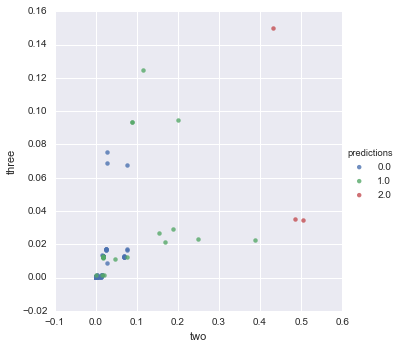

In [2529]:
sns.lmplot('two', 'three', data=dc, hue='predictions', fit_reg=False)

In [2550]:
# Won't include Off the Record because it is a bar -- not a restaurant.
dc.loc[(dc.predictions > 0) & (dc.two + dc.three > 0.03)]

,restaurant,rest_id,rating,price,num_reviews,category,text,natm,predictions,none,one,two,three,svm,rfc,gbc,knn
2,Komi,komi-washington,4.5,3,644,greek mediterranean,greek mediterranean Fantastic. I hope they get...,0,2.0,0.007659,0.410651,0.431709,0.149980,1.0,2.0,1.0,2.0
15,Pineapple & Pearls,pineapple-and-pearls-washington-3,4.5,3,78,breakfast_brunch cafes sandwiches,breakfast_brunch cafes sandwiches FYI: This re...,0,1.0,0.011342,0.771841,0.187754,0.029063,1.0,1.0,1.0,1.0
29,Makoto Restaurant,makoto-restaurant-washington,4.5,3,354,japanese,japanese My friend David and I came here for a...,0,2.0,0.004785,0.475842,0.484431,0.034942,1.0,2.0,2.0,1.0
32,1789 Restaurant,1789-restaurant-washington-4,4.0,3,538,tradamerican,tradamerican President Barack Obama.\nChancell...,0,1.0,0.026278,0.702296,0.248159,0.023267,1.0,2.0,1.0,1.0
44,Filomena Ristorante,filomena-ristorante-washington,4.0,2,1521,italian,italian I haven't given 5 stars in a long time...,0,1.0,0.400926,0.567899,0.018052,0.013124,1.0,1.0,1.0,1.0
75,Off The Record,off-the-record-washington,4.0,2,178,bars newamerican,bars newamerican Located inside of the Hay Ada...,1,1.0,0.463842,0.505450,0.018153,0.012554,1.0,0.0,0.0,1.0
85,Osteria Morini,osteria-morini-washington,4.0,2,358,italian,italian Osteria Morini is advertised on google...,0,1.0,0.429213,0.482556,0.075914,0.012317,1.0,0.0,0.0,1.0
89,Unum,unum-washington-2,4.0,2,272,newamerican cocktailbars,newamerican cocktailbars Wandered in here on a...,1,1.0,0.357294,0.611792,0.018294,0.012620,1.0,1.0,1.0,0.0
171,Hazel,hazel-washington,4.0,2,46,newamerican,newamerican Although there's a lot of good foo...,1,1.0,0.178759,0.790605,0.018145,0.012491,1.0,1.0,1.0,1.0
190,Kinship,kinship-washington,4.0,3,106,newamerican desserts diners,newamerican desserts diners Everything you've ...,1,1.0,0.001470,0.817402,0.154532,0.026595,1.0,1.0,1.0,1.0
